In [59]:
import bankfind as bf
import pandas as pd
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from pprint import pprint
import matplotlib.pyplot as plt
import requests
from folium.plugins import MarkerCluster

In [37]:
# Get data on failed financial institutions
#FDIC allows direct import of different modules. This one just asks for faield banks.
data = bf.get_failures()

# Inspect the structure of the data
print(type(data))

<class 'dict'>


In [38]:
#This is what a single data entry for a failed bank looks like.
#Note: We'll need to clean this up, reorder it.
data['data'][0]

{'QBFDEP': 64941,
 'PSTALP': 'KS',
 'FIN': '10538',
 'FAILDATE': '10/23/2020',
 'RESTYPE': 'FAILURE',
 'CITYST': 'ALMENA, KS',
 'SAVR': 'DIF',
 'RESTYPE1': 'PA',
 'CHCLASS1': 'NM',
 'NAME': 'ALMENA STATE BANK',
 'COST': 16806,
 'QBFASSET': 65733,
 'CERT': 15426,
 'FAILYR': '2020',
 'ID': '4104'}

In [39]:
#Create a dataframe that hosts all of the data for each failed bank.
#This will need to be cleaned up. 
data = bf.get_failures()
df = pd.DataFrame(data['data'])
df

,QBFDEP,PSTALP,FIN,FAILDATE,RESTYPE,CITYST,SAVR,RESTYPE1,CHCLASS1,NAME,COST,QBFASSET,CERT,FAILYR,ID
0,64941.0,KS,10538,10/23/2020,FAILURE,"ALMENA, KS",DIF,PA,NM,ALMENA STATE BANK,16806.0,65733.0,15426.0,2020,4104
1,133936.0,FL,10537,10/16/2020,FAILURE,"FORT WALTON BEACH, FL",DIF,PA,NM,FIRST CITY BANK OF FLORIDA,7247.0,136566.0,16748.0,2020,4103
2,143102.0,WV,10536,4/3/2020,FAILURE,"BARBOURSVILLE, WV",DIF,PA,NM,THE FIRST STATE BANK,45913.0,151808.0,14361.0,2020,4102
3,95159.0,NE,10535,2/14/2020,FAILURE,"ERICSON, NE",DIF,PA,NM,ERICSON STATE BANK,25293.0,100879.0,18265.0,2020,4101
4,111234.0,NJ,10534,11/1/2019,FAILURE,"NEWARK, NJ",DIF,PA,N,CITY NATIONAL BANK OF NEW JERSEY,1946.0,120574.0,21111.0,2019,4100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,68.0,KY,0,8/6/1934,FAILURE,"LEWISPORT, KY",BIF,PO,NM,BANK OF LEWISPORT,NaN,81.0,NaN,1934,137
4100,42.0,MT,0,7/18/1934,FAILURE,"LIMA, MT",BIF,PO,N,FIRST NATIONAL BANK OF LIMA,NaN,91.0,NaN,1934,135
4101,69.0,IN,0,7/18/1934,FAILURE,"FLORENCE, IN",BIF,PO,NM,FLORENCE DEPOSIT BANK,NaN,105.0,NaN,1934,136
4102,238.0,IL,0,5/28/1934,FAILURE,"EAST PEORIA, IL",BIF,PO,NM,FON DU LAC STATE BANK,NaN,374.0,NaN,1934,133


In [40]:
# Rename the columns
new_columns = {
    'QBFDEP': 'Deposits',
    'PSTALP': 'State',
    'FIN': 'Fed RSSD',
    'FAILDATE': 'Failure Date',
    'RESTYPE': 'Resolution Type',
    'CITYST': 'City/State',
    'SAVR': 'SAVR',
    'RESTYPE1': 'Resolution Type 1',
    'CHCLASS1': 'Charter Class 1',
    'NAME': 'Bank Name',
    'COST': 'Cost',
    'QBFASSET': 'Assets',
    'CERT': 'FDIC Cert',
    'FAILYR': 'Failure Year',
    'ID': 'ID'
}

df = df.rename(columns=new_columns)

# Reorder the columns, creates a loop that arbritraily lists the reamining columns after a specified order
df = df[['Bank Name', 'ID', 'State', 'Failure Date', 'Failure Year', 'Assets', 'Deposits']+ [c for c in df.columns if c not in ['Bank Name', 'ID', 'State', 'Failure Date', 'Failure Year', 'Assets', 'Deposits']]]

df.head()

,Bank Name,ID,State,Failure Date,Failure Year,Assets,Deposits,Fed RSSD,Resolution Type,City/State,SAVR,Resolution Type 1,Charter Class 1,Cost,FDIC Cert
0,ALMENA STATE BANK,4104,KS,10/23/2020,2020,65733.0,64941.0,10538,FAILURE,"ALMENA, KS",DIF,PA,NM,16806.0,15426.0
1,FIRST CITY BANK OF FLORIDA,4103,FL,10/16/2020,2020,136566.0,133936.0,10537,FAILURE,"FORT WALTON BEACH, FL",DIF,PA,NM,7247.0,16748.0
2,THE FIRST STATE BANK,4102,WV,4/3/2020,2020,151808.0,143102.0,10536,FAILURE,"BARBOURSVILLE, WV",DIF,PA,NM,45913.0,14361.0
3,ERICSON STATE BANK,4101,NE,2/14/2020,2020,100879.0,95159.0,10535,FAILURE,"ERICSON, NE",DIF,PA,NM,25293.0,18265.0
4,CITY NATIONAL BANK OF NEW JERSEY,4100,NJ,11/1/2019,2019,120574.0,111234.0,10534,FAILURE,"NEWARK, NJ",DIF,PA,N,1946.0,21111.0


In [41]:
# Convert the 'Failure Year' column to integer
df['Failure Year'] = df['Failure Year'].astype(int)

# Filter out the rows with a 'Failure Year' of 1950 or earlier
df = df[df['Failure Year'] > 1950]
df.head()

,Bank Name,ID,State,Failure Date,Failure Year,Assets,Deposits,Fed RSSD,Resolution Type,City/State,SAVR,Resolution Type 1,Charter Class 1,Cost,FDIC Cert
0,ALMENA STATE BANK,4104,KS,10/23/2020,2020,65733.0,64941.0,10538,FAILURE,"ALMENA, KS",DIF,PA,NM,16806.0,15426.0
1,FIRST CITY BANK OF FLORIDA,4103,FL,10/16/2020,2020,136566.0,133936.0,10537,FAILURE,"FORT WALTON BEACH, FL",DIF,PA,NM,7247.0,16748.0
2,THE FIRST STATE BANK,4102,WV,4/3/2020,2020,151808.0,143102.0,10536,FAILURE,"BARBOURSVILLE, WV",DIF,PA,NM,45913.0,14361.0
3,ERICSON STATE BANK,4101,NE,2/14/2020,2020,100879.0,95159.0,10535,FAILURE,"ERICSON, NE",DIF,PA,NM,25293.0,18265.0
4,CITY NATIONAL BANK OF NEW JERSEY,4100,NJ,11/1/2019,2019,120574.0,111234.0,10534,FAILURE,"NEWARK, NJ",DIF,PA,N,1946.0,21111.0


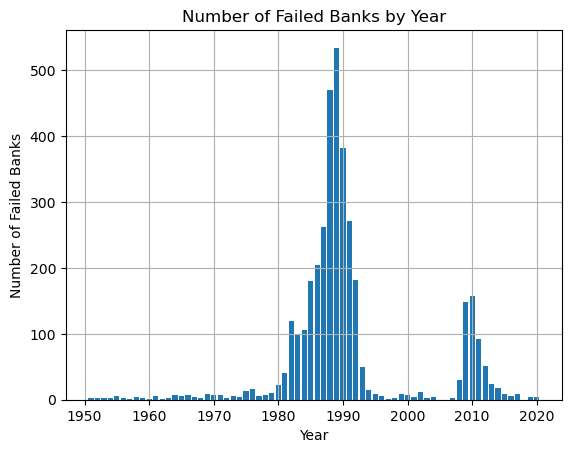

In [42]:
# Group the data by year and count the number of banks that failed each year
failures_per_year = df.groupby('Failure Year').size()

# Create a bar chart of the data
fig, ax = plt.subplots()
ax.bar(failures_per_year.index, failures_per_year.values)

# Set the chart title and axis labels
ax.set_title('Number of Failed Banks by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Failed Banks')

# Set the x-axis tick locations and labels to show only every 10 years, starting at the nearest multiple of 10 greater than or equal to 1950
start_year = (1950 // 10) * 10
ax.set_xticks(range(start_year, failures_per_year.index[-1]+1, 10))

# Add grid lines
ax.grid(True, axis='y')
ax.grid(True, axis='x')

# Display the chart
plt.show()

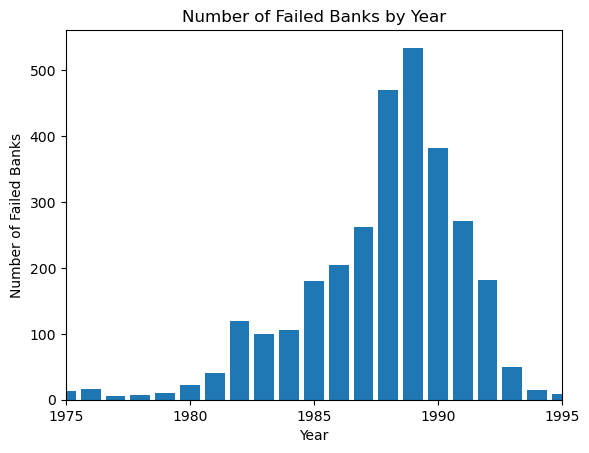

In [43]:
# Group the data by year and count the number of banks that failed each year
failures_per_year = df.groupby('Failure Year').size()

# Create a bar chart of the data
plt.bar(failures_per_year.index, failures_per_year.values)

# Set the chart title and axis labels
plt.title('Number of Failed Banks by Year')
plt.xlabel('Year')
plt.ylabel('Number of Failed Banks')

# Set the x-axis tick locations and labels to show only every 5 years between 1975 and 1995
plt.xticks(range(1975, 1996, 5))

# Limit the x-axis range to only show between 1975 and 1995
plt.xlim(1975, 1995)

# Display the chart
plt.show()

## Bank Failures in Brief – Summary 80s through 90s
"The rise in the number of bank failures in the 1980s had no single cause or short list of causes. Rather, it resulted from a concurrence of various forces working to gether to produce a decade of banking crises." https://www.fdic.gov/analysis/archived-research/banking-review/brspecial.pdf

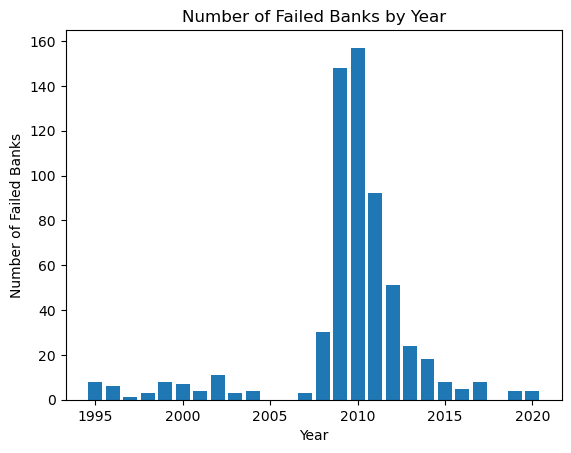

In [44]:
# Filter the data to only include years between 1995 and 2023
failures_per_year = failures_per_year.loc[1995:2023]

# Create a bar chart of the data
plt.bar(failures_per_year.index, failures_per_year.values)

# Set the chart title and axis labels
plt.title('Number of Failed Banks by Year')
plt.xlabel('Year')
plt.ylabel('Number of Failed Banks')

# Set the x-axis tick locations and labels to show only every 5 years between 1995 and 2023
plt.xticks(range(1995, 2024, 5), range(1995, 2024, 5))

# Display the chart
plt.show()

## Bank Failures in Brief – Summary 2001 through 2023
https://www.fdic.gov/bank/historical/bank/

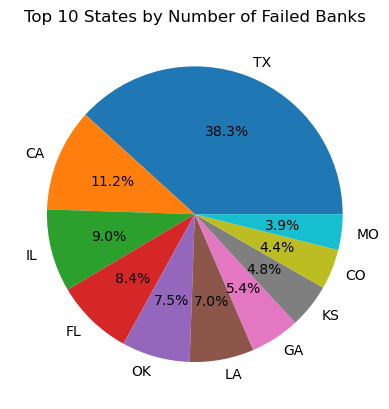

In [45]:
# Get the top 10 states by number of failed banks
top_10_states = df.groupby('State').size().sort_values(ascending=False).head(10)

# Create a pie chart of the top 10 states
plt.pie(top_10_states, labels=top_10_states.index,  autopct='%1.1f%%')

# Set the chart title
plt.title('Top 10 States by Number of Failed Banks')

# Display the chart
plt.show()

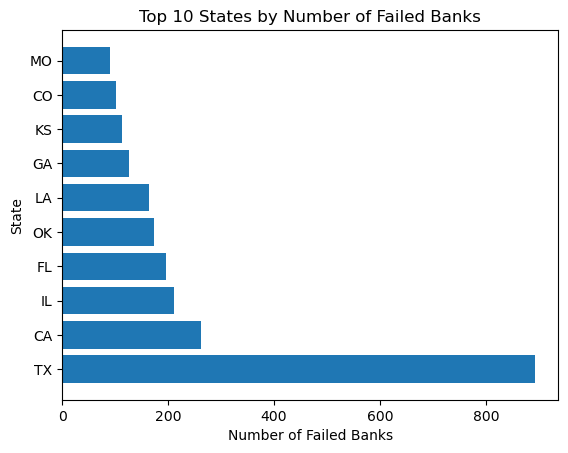

In [46]:
# Get the top 10 states by number of failed banks
top_10_states = df.groupby('State').size().sort_values(ascending=False).head(10)

# Create a horizontal bar chart of the top 10 states
plt.barh(top_10_states.index, top_10_states.values)

# Set the chart title and axis labels
plt.title('Top 10 States by Number of Failed Banks')
plt.xlabel('Number of Failed Banks')
plt.ylabel('State')

# Display the chart
plt.show()

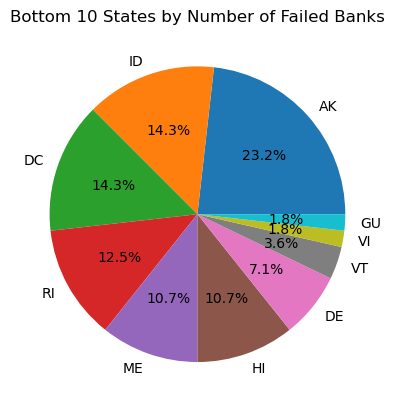

In [47]:
# Group the data by state and count the number of banks that failed in each state
failures_by_state = df.groupby('State').size().sort_values(ascending=False)

# Get the bottom 10 states by number of failed banks
bottom_10_states = failures_by_state.tail(10)

# Create a pie chart of the bottom 10 states
plt.pie(bottom_10_states, labels=bottom_10_states.index,  autopct='%1.1f%%')

# Set the chart title
plt.title('Bottom 10 States by Number of Failed Banks')

# Display the chart
plt.show()

# poissbly different type of chart here? Maybe bar chart?

In [49]:
new_df = df[['Bank Name', 'City/State', 'Failure Year']]

In [50]:
# set Geoapify API key
API_KEY = "5ea46e0aae3948818dce6e65b8156ab3"
BASE_URL = "https://api.geoapify.com/v1/geocode/search"

# create empty lists to store the latitude and longitude values
latitudes = []
longitudes = []

# loop through each row in the dataframe and geocode the city/state
for index, row in new_df.head(1000).iterrows():
    location = f"{row['City/State']}, USA"
    params = {"text": location, "apiKey": API_KEY}
    response = requests.get(BASE_URL, params=params).json()
    
    # check if any results were found
    if response["features"]:
        # get the first result and extract the latitude and longitude
        coordinates = response["features"][0]["geometry"]["coordinates"]
        latitudes.append(coordinates[1])
        longitudes.append(coordinates[0])
    else:
        # if no results were found, add NaN values to the lists
        latitudes.append(float("NaN"))
        longitudes.append(float("NaN"))
    
    # print a message every 50 records
    if index % 50 == 0:
        print(f"Processed {index} records...")
        
# create a new dataframe
new_df_100 = new_df.head(1000).copy()

# add the latitude and longitude columns to the new dataframe
new_df_100['Latitude'] = latitudes
new_df_100['Longitude'] = longitudes

new_df_100.head(5)

Processed 0 records...
Processed 50 records...
Processed 100 records...
Processed 150 records...
Processed 200 records...
Processed 250 records...
Processed 300 records...
Processed 350 records...
Processed 400 records...
Processed 450 records...
Processed 500 records...
Processed 550 records...
Processed 600 records...
Processed 650 records...
Processed 700 records...
Processed 750 records...
Processed 800 records...
Processed 850 records...
Processed 900 records...
Processed 950 records...


,Bank Name,City/State,Failure Year,Latitude,Longitude
0,ALMENA STATE BANK,"ALMENA, KS",2020,39.892229,-99.707058
1,FIRST CITY BANK OF FLORIDA,"FORT WALTON BEACH, FL",2020,30.405755,-86.618842
2,THE FIRST STATE BANK,"BARBOURSVILLE, WV",2020,38.409530,-82.294592
3,ERICSON STATE BANK,"ERICSON, NE",2020,41.779924,-98.678582
4,CITY NATIONAL BANK OF NEW JERSEY,"NEWARK, NJ",2019,40.735657,-74.172367


In [71]:
# create a map centered on the US
map_usa = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# add a marker for each location
for index, row in new_df_100.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=1,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.1,  # change the fill opacity
        popup=row['City/State'],
    ).add_to(map_usa)

# display the map
map_usa

In [52]:
# create a map centered on the US
map_usa = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# create a list of points as [latitude, longitude] pairs
locations = new_df_100[['Latitude', 'Longitude']].values.tolist()

# create the heat map layer and add it to the map
heat_layer = HeatMap(locations)
map_usa.add_child(heat_layer)

# display the map
map_usa

#condense the heatmap, so the datat isnt overwehelming
#bubble chart

In [61]:
from sklearn.cluster import KMeans

# create a list of points as [latitude, longitude] pairs for all years
locations_all = new_df_100[['Latitude', 'Longitude']]

# cluster the data using K-Means
kmeans = KMeans(n_clusters=10, random_state=42).fit(locations_all)

# add cluster labels to the data
locations_all['cluster'] = kmeans.labels_

# compute the centroids of each cluster
centroids = kmeans.cluster_centers_

# create a heatmap of the cluster centroids
map_clusters = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
heat_layer_clusters = HeatMap(centroids.tolist())
map_clusters.add_child(heat_layer_clusters)
display(map_clusters)

C:\Users\elijt\AppData\Local\Temp\ipykernel_2736\4270435928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations_all['cluster'] = kmeans.labels_


In [64]:
all_years_df = new_df_100.copy()

# create dataframe for 1980-1995
df_1980_1995 = new_df_100[(new_df_100['Failure Year'] >= 1980) & (df['Failure Year'] <= 1995)].copy()

# create dataframe for 2000-2020
df_2000_2020 = new_df_100[new_df_100['Failure Year'].between(2000, 2020)].copy()

C:\Users\elijt\AppData\Local\Temp\ipykernel_2736\1546408834.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1980_1995 = new_df_100[(new_df_100['Failure Year'] >= 1980) & (df['Failure Year'] <= 1995)].copy()


In [65]:
map_all_years = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
map_1980_1995 = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
map_2000_2020 = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# create a list of points as [latitude, longitude] pairs for all years
locations_all = new_df_100[['Latitude', 'Longitude']].values.tolist()

# create the heat map 
heat_layer_all = HeatMap(locations_all)
map_all_years.add_child(heat_layer_all)

# create a list of points as [latitude, longitude] pairs for 1980-1995
df_1980_1995 = new_df_100[new_df_100['Failure Year'].between(1980, 1995)]
locations_1980_1995 = df_1980_1995[['Latitude', 'Longitude']].values.tolist()


heat_layer_1980_1995 = HeatMap(locations_1980_1995)
map_1980_1995.add_child(heat_layer_1980_1995)

# create a list of points [latitude, longitude] for 2000-2020
df_2000_2020 = new_df_100[new_df_100['Failure Year'].between(2000, 2020)]
locations_2000_2020 = df_2000_2020[['Latitude', 'Longitude']].values.tolist()


heat_layer_2000_2020 = HeatMap(locations_2000_2020)
map_2000_2020.add_child(heat_layer_2000_2020)

display(map_all_years)

In [67]:
from sklearn.cluster import KMeans

# create a list of points as [latitude, longitude] pairs for all years
locations_all = new_df_100[['Latitude', 'Longitude']]

# create a list of points as [latitude, longitude] pairs for 1980-1995
df_1980_1995 = new_df_100[new_df_100['Failure Year'].between(1980, 1995)]
locations_1980_1995 = df_1980_1995[['Latitude', 'Longitude']]

# create a list of points [latitude, longitude] for 2000-2020
df_2000_2020 = new_df_100[new_df_100['Failure Year'].between(2000, 2020)]
locations_2000_2020 = df_2000_2020[['Latitude', 'Longitude']]

# cluster the data for all years using K-Means
kmeans_all = KMeans(n_clusters=10, random_state=42).fit(locations_all)
locations_all['cluster'] = kmeans_all.labels_
centroids_all = kmeans_all.cluster_centers_

# cluster the data for 1980-1995 using K-Means
kmeans_1980_1995 = KMeans(n_clusters=10, random_state=42).fit(locations_1980_1995)
locations_1980_1995['cluster'] = kmeans_1980_1995.labels_
centroids_1980_1995 = kmeans_1980_1995.cluster_centers_

# cluster the data for 2000-2020 using K-Means
kmeans_2000_2020 = KMeans(n_clusters=10, random_state=42).fit(locations_2000_2020)
locations_2000_2020['cluster'] = kmeans_2000_2020.labels_
centroids_2000_2020 = kmeans_2000_2020.cluster_centers_

# create the maps and heatmaps for each cluster
map_all_years = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
heat_layer_all = HeatMap(centroids_all.tolist())
map_all_years.add_child(heat_layer_all)

map_1980_1995 = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
heat_layer_1980_1995 = HeatMap(centroids_1980_1995.tolist())
map_1980_1995.add_child(heat_layer_1980_1995)

map_2000_2020 = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
heat_layer_2000_2020 = HeatMap(centroids_2000_2020.tolist())
map_2000_2020.add_child(heat_layer_2000_2020)

# display the maps
display(map_all_years)

C:\Users\elijt\AppData\Local\Temp\ipykernel_2736\2690112820.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations_all['cluster'] = kmeans_all.labels_
C:\Users\elijt\AppData\Local\Temp\ipykernel_2736\2690112820.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations_1980_1995['cluster'] = kmeans_1980_1995.labels_
C:\Users\elijt\AppData\Local\Temp\ipykernel_2736\2690112820.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [68]:
display(map_1980_1995)

In [69]:
display(map_2000_2020)

In [83]:
# create a new column 'Difference' that calculates the difference between 'Deposits' and 'Assets' only where 'Deposits' are larger than 'Assets'
df_new.loc[df_new['Deposits'] > df_new['Assets'], 'Difference'] = df_new['Deposits'] - df_new['Assets']


# select only the columns you want to keep
df_new = df_new[['Bank Name', 'State', 'Failure Year', 'Assets', 'Deposits']]

# display the new dataframe
df_new = df_new.tail(10)

# display the new dataframe
df_new.head()

,Bank Name,State,Failure Year,Assets,Deposits
3676,JOSHUA MONUMENT NAT BANK-TWENTYNINE PALMS,CA,1955,3111.0,3714.0
3687,THE PARNASSUS NATIONAL BANK,PA,1951,2906.0,3260.0
3643,FIVE POINTS NATIONAL BANK,FL,1966,2703.0,2967.0
3618,FARMERS BANK OF PETERSBURG,KY,1970,1074.0,1259.0
3686,THOMASVILLE BANK AND TRUST CO.,AL,1952,1031.0,1757.0


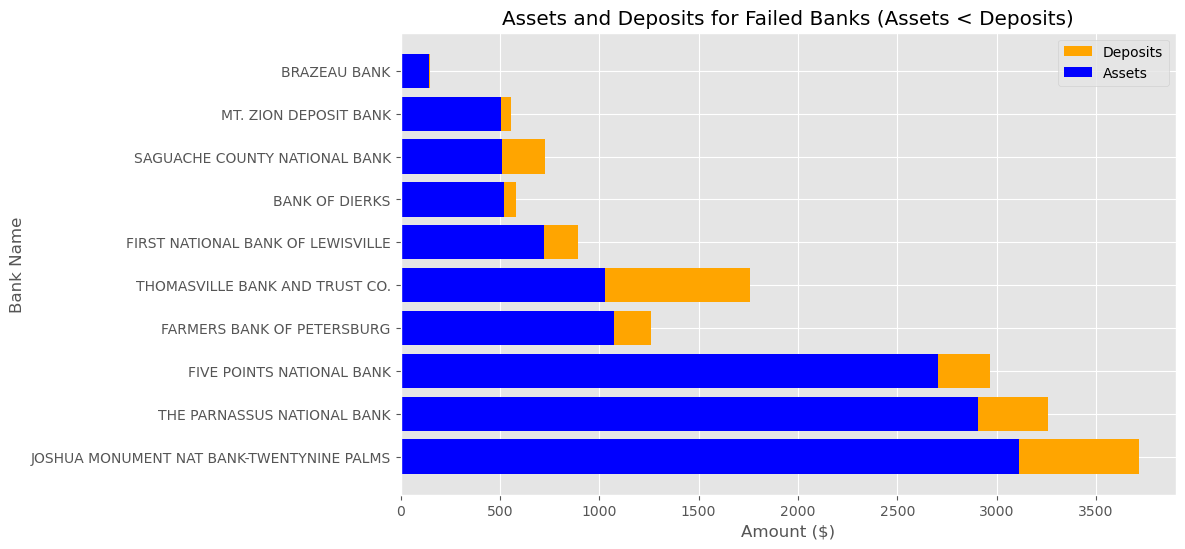

In [84]:
import matplotlib.pyplot as plt

# sort the dataframe by Assets in descending order
df_new = df_new.sort_values(by='Assets', ascending=False)

# set the plot style
plt.style.use('ggplot')

# create the plot
plt.figure(figsize=(10, 6))
plt.barh(y=df_new['Bank Name'], width=df_new['Deposits'], color='orange', label='Deposits')
plt.barh(y=df_new['Bank Name'], width=df_new['Assets'], color='blue', label='Assets')
plt.xlabel('Amount ($)')
plt.ylabel('Bank Name')
plt.title('Assets and Deposits for Failed Banks (Assets < Deposits)')
plt.legend()
plt.show()